In [59]:
import sys
# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('./secrets.py')

import logging
import math
import os

from influxdb import DataFrameClient
import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
%matplotlib inline

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Need to ssh tunnel for this to work
# ssh -L 8086:localhost:8086 aq.byu.edu -N
influx = DataFrameClient(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD,
    database=DATABASE,
)


def large_query(influx, measurement, query, total=None, limit=100_000):
    if total is not None:
        total = math.ceil(total / limit)

    with tqdm(total=total) as pbar:
        offset = 0
        while True:
            new_query = query + " LIMIT {} OFFSET {}".format(limit, offset)
            data = influx.query(new_query)
            data = data[measurement]

            received = len(data)
            pbar.update(1)

            yield data

            offset += limit
            if received != limit:
                break


def load_data(filename):
    if os.path.exists(filename):
        LOGGER.info("Loading cached data...")
        return pd.read_hdf(filename)

    LOGGER.info("Downloading data...")
    result = influx.query(
        "SELECT COUNT(sequence) FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()"
    )
    count = result["air_quality_sensor"].values[0][0]

    queries = large_query(
        influx,
        "air_quality_sensor",
        "SELECT * FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()",
        count,
    )

    all_data = pd.concat(list(queries), sort=False)
    all_data.to_hdf(filename, "data")
    return all_data


data = load_data("aq_data.h5")
LOGGER.info("Done loading data...")


INFO:__main__:Loading cached data...
INFO:__main__:Done loading data...


In [48]:
data

,card_present,cellular,co2,current,deployed,event,fw_version,humidity,location,location_name,...,reset_reason_data,rtc_temperature,sensor_id,sequence,serial_number,stay_at_home,system_firmware_version,temperature,total_energy,voltage
2019-11-04 00:00:01+00:00,False,True,1524.0,5.511,True,mn/d,3,54.9,"[47.935, 106.836]",Mongolia,...,NaN,NaN,e00fce686c8734b91819de91,66436,B31KAB9106NA4SG,True,1.4.0,18.6,12.258,208.0
2019-11-04 00:00:02+00:00,None,True,1109.0,5.981,True,mn/d,2,54.0,"[47.936, 106.834]",Mongolia,...,NaN,29.50,e00fce68068d755f7bf0ec7b,66392,B31KAB913CUH4MY,True,1.4.0,19.4,112.825,225.0
2019-11-04 00:00:03+00:00,None,True,1217.0,NaN,True,mn/d,2,69.2,"[47.927, 106.83]",Mongolia,...,NaN,17.75,e00fce68fad0292979e94e3e,61592,B31KAB9134ACERV,False,1.4.0,8.0,NaN,NaN
2019-11-04 00:00:06+00:00,False,True,1584.0,NaN,True,mn/d,3,48.4,"[47.937, 106.84]",Mongolia,...,NaN,27.50,e00fce68cbf6aec1112a30c0,63904,B31KAB913G5AWSR,False,1.4.0,15.6,NaN,NaN
2019-11-04 00:00:07+00:00,None,True,2272.0,2.547,True,mn/d,2,40.6,"[47.935, 106.836]",Mongolia,...,NaN,32.50,e00fce68c77425e3c1e14821,20769,B31KAB913XVT47R,False,1.4.0,22.0,7.608,230.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-24 00:15:01+00:00,False,True,967.0,NaN,True,mn/d,3,18.2,"[47.922, 106.823]",Mongolia,...,NaN,27.00,e00fce68189c74034137ad0d,145512,B31KAB913SA78EW,False,1.4.0,20.2,NaN,NaN
2020-01-24 00:15:17+00:00,False,True,NaN,NaN,True,mn/d,3,NaN,None,Mongolia,...,NaN,19.75,e00fce687bf925e55a89a6c6,43270,B31KAB913B5XEPK,None,1.4.2,NaN,NaN,NaN
2020-01-24 00:15:33+00:00,True,True,454.0,NaN,True,mn/d,3,19.1,"[47.917, 106.829]",Mongolia,...,NaN,24.50,e00fce686ec1c40e79b5657d,131868,B31KAB913K4LPHJ,True,1.4.0,15.4,NaN,NaN
2020-01-24 00:16:01+00:00,False,True,964.0,NaN,True,mn/d,3,18.2,"[47.922, 106.823]",Mongolia,...,NaN,27.25,e00fce68189c74034137ad0d,145513,B31KAB913SA78EW,False,1.4.0,20.5,NaN,NaN


In [49]:
num_bins = 10
n, bins, patches = plt.hist(data.voltage.values, num_bins, facecolor='blue', alpha=0.5)
plt.show()

2019-11-04 00:00:01+00:00     62.0
2019-11-04 00:00:02+00:00      2.0
2019-11-04 00:00:03+00:00     18.0
2019-11-04 00:00:06+00:00      8.0
2019-11-04 00:00:07+00:00     13.0
                             ...  
2020-01-24 00:15:01+00:00    111.0
2020-01-24 00:15:17+00:00      NaN
2020-01-24 00:15:33+00:00     18.0
2020-01-24 00:16:01+00:00    110.0
2020-01-24 00:17:01+00:00    112.0
Name: pm2_5, Length: 3915170, dtype: float64

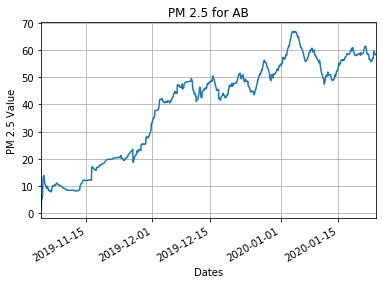

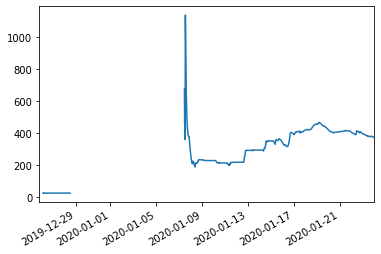

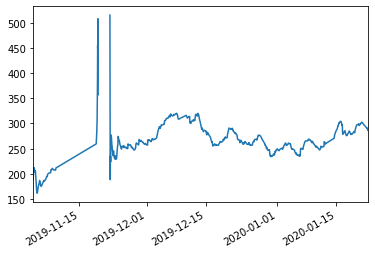

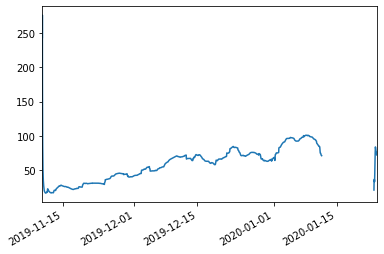

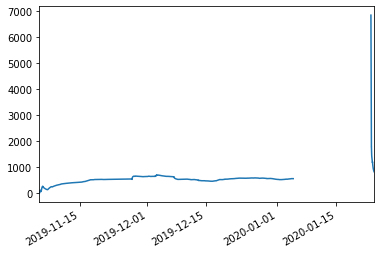

In [81]:
# for name, sensor_data in data.groupby("name"):
#     print("Sensor:", name)
#     sensor_data["pm2_5"].rolling("10d").mean().plot()

data.groupby("name").get_group("CA")["pm2_5"].rolling("10d").mean().plot()
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('PM 2.5 for AB')
plt.grid(True)
# fig = plt.subplots()
# fig.savefig("ab.png")
plt.savefig("{}_pm_2_5.png".format("AB"), format='png')
plt.show()

data.groupby("name").get_group("AB")["pm2_5"].rolling("10d").mean().plot()
plt.show()
data.groupby("name").get_group("AK")["pm2_5"].rolling("10d").mean().plot()
plt.show()
data.groupby("name").get_group("AL")["pm2_5"].rolling("10d").mean().plot()
plt.show()
data.groupby("name").get_group("AR")["pm2_5"].rolling("10d").mean().plot()
plt.show()